In [1]:
# import packages
import pandas as pd
import numpy as np

In [6]:
## load model

from gensim.models import Word2Vec

w2v = Word2Vec.load("word2vec_model")
word_vectors = w2v.wv

In [7]:
# cluster the word into 2 clusters

from sklearn.cluster import KMeans

model = KMeans(n_clusters=2, max_iter=1000, random_state=True, n_init=50).fit(X=word_vectors.vectors)
cluster_center1 = model.cluster_centers_[0]
cluster_center2 = model.cluster_centers_[1]

In [12]:
# identify positive and negative cluster

word_vectors.similar_by_vector(model.cluster_centers_[0], topn=10, restrict_vocab=None)

[('distribution', 0.6704285144805908),
 ('expanding', 0.6407636404037476),
 ('contributing', 0.6359766721725464),
 ('crippling', 0.6349374651908875),
 ('harmful', 0.6314553618431091),
 ('availability', 0.6271024346351624),
 ('limiting', 0.6193970441818237),
 ('consumption', 0.6154929399490356),
 ('censorship', 0.6102221012115479),
 ('flows', 0.6098132729530334)]

In [53]:
word_vectors.similar_by_vector(model.cluster_centers_[1], topn=10, restrict_vocab=None)

[('omg', 0.803366482257843),
 ('myers', 0.797511875629425),
 ('patterson', 0.7758046388626099),
 ('brandon', 0.7732713222503662),
 ('danny', 0.7698471546173096),
 ('tommy', 0.7621939182281494),
 ('julia', 0.7600942850112915),
 ('hoffman', 0.7554521560668945),
 ('robin', 0.7543211579322815),
 ('dixon', 0.7536131143569946)]

In [14]:
# create word sentiment dataframe
words = pd.DataFrame(word_vectors.vocab.keys())
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors.wv[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: model.predict(np.array([x])))
words.cluster = words.cluster.apply(lambda x: x[0])
words['cluster_value'] = [1 if i==1 else -1 for i in words.cluster]
words['closeness_score'] = words.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)
words['sentiment_coeff'] = words.closeness_score * words.cluster_value

<ipython-input-14-9434a558d071>:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  words['vectors'] = words.words.apply(lambda x: word_vectors.wv[f'{x}'])


In [24]:
sentiment_dict = dict(zip(words.words.values, words.sentiment_coeff.values))

In [25]:
words[['words', 'sentiment_coeff']].to_csv('sentiment_dictionary.csv', index=False)

In [26]:
df = pd.read_csv('news_processed.csv')

In [27]:
df.head()

,title_aft,text_aft,subject,date,target,combined
0,donald trump sends embarrassing new year eve m...,donald trump wish american happy new year leav...,News,"December 31, 2017",1,donald trump sends embarrassing new year eve m...
1,drunk bragging trump staffer started russian c...,house intelligence committee chairman devin nu...,News,"December 31, 2017",1,drunk bragging trump staffer started russian c...
2,sheriff david clarke becomes internet joke thr...,friday revealed former milwaukee sheriff david...,News,"December 30, 2017",1,sheriff david clarke becomes internet joke thr...
3,trump obsessed even obama name coded website i...,christmas day donald trump announced would bac...,News,"December 29, 2017",1,trump obsessed even obama name coded website i...
4,pope francis called donald trump christmas speech,pope francis used annual christmas day message...,News,"December 25, 2017",1,pope francis called donald trump christmas spe...


In [28]:
# get TFIDF score of words
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(tokenizer=lambda y: y.split(), norm=None)
tfidf.fit(df.combined)
features = pd.Series(tfidf.get_feature_names())
transformed = tfidf.transform(df.combined)

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [29]:
def create_tfidf_dictionary(x, transformed_file, features):
    '''
    create dictionary for each input sentence x, where each word has assigned its tfidf score
    
    inspired  by function from this wonderful article: 
    https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34
    
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer

    '''
    vector_coo = transformed_file[x.name].tocoo()
    vector_coo.col = features.iloc[vector_coo.col].values
    dict_from_coo = dict(zip(vector_coo.col, vector_coo.data))
    return dict_from_coo

def replace_tfidf_words(x, transformed_file, features):
    '''
    replacing each word with it's calculated tfidf dictionary with scores of each word
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer
    '''
    dictionary = create_tfidf_dictionary(x, transformed_file, features)   
    return list(map(lambda y:dictionary[f'{y}'], x.combined.split()))

In [30]:
replaced_tfidf_scores = df.apply(lambda x: replace_tfidf_words(x, transformed, features), axis=1)

In [31]:
def replace_sentiment_words(word, sentiment_dict):
    '''
    replacing each word with its associated sentiment score from sentiment dict
    '''
    try:
        out = sentiment_dict[word]
    except KeyError:
        out = 0
    return out

In [32]:
replaced_closeness_scores = df.combined.apply(lambda x: list(map(lambda y: replace_sentiment_words(y, sentiment_dict), x.split())))

In [33]:
# get dot product of TFIDF and sentiment score vectors
replacement_df = pd.DataFrame(data=[replaced_closeness_scores, replaced_tfidf_scores, df.combined, df.target]).T
replacement_df.columns = ['sentiment_coeff', 'tfidf_scores', 'sentence', 'target']
replacement_df['sentiment_rate'] = replacement_df.apply(lambda x: np.array(x.loc['sentiment_coeff']) @ np.array(x.loc['tfidf_scores']), axis=1)
replacement_df['prediction'] = (replacement_df.sentiment_rate>0).astype('int8')


In [34]:
replacement_df = replacement_df[['sentence', 'sentiment_rate', 'target', 'prediction']]

In [36]:
# Evaluation (checking number of records with positive and negative sentiments in fake news)

replacement_df[(replacement_df['target'] == 1) & (replacement_df['prediction'] == 0)].count()

sentence          12618
sentiment_rate    12618
target            12618
prediction        12618
dtype: int64

In [37]:
replacement_df[(replacement_df['target'] == 1) & (replacement_df['prediction'] == 1)].count()

sentence          10232
sentiment_rate    10232
target            10232
prediction        10232
dtype: int64

In [38]:
# Evaluation (checking number of records with positive and real sentiments in fake news)
replacement_df[(replacement_df['target'] == 0) & (replacement_df['prediction'] == 1)].count()

sentence          4048
sentiment_rate    4048
target            4048
prediction        4048
dtype: int64

In [39]:
replacement_df[(replacement_df['target'] == 0) & (replacement_df['prediction'] == 0)].count()

sentence          17368
sentiment_rate    17368
target            17368
prediction        17368
dtype: int64

In [44]:
replacement_df.to_csv('df_sentiment.csv', index=False)

In [45]:
# Visualization

replacement_df['sentiment'] = replacement_df.apply(lambda x: 'negative' if x['prediction'] == 0 else 'positive', axis=1)
replacement_df['type'] = replacement_df.apply(lambda x: 'fake' if x['target'] == 1 else 'real', axis=1)

In [46]:
replacement_df.head()

,sentence,sentiment_rate,target,prediction,sentiment,type
0,donald trump sends embarrassing new year eve m...,-428.255271,1,0,negative,fake
1,drunk bragging trump staffer started russian c...,313.524585,1,1,positive,fake
2,sheriff david clarke becomes internet joke thr...,1195.765412,1,1,positive,fake
3,trump obsessed even obama name coded website i...,758.902219,1,1,positive,fake
4,pope francis called donald trump christmas spe...,102.499073,1,1,positive,fake


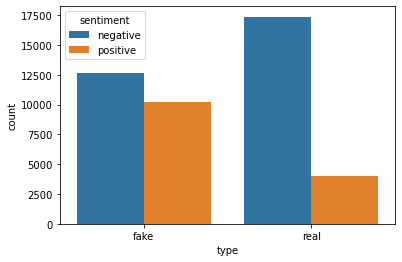

In [47]:
import seaborn as sns

ax = sns.countplot(x="type", data=replacement_df, hue='sentiment')


In [49]:
ax.figure.savefig('sentiment.jpg')